In [42]:
import pandas as pd
import os
pd.set_option('display.max_colwidth', None)
from PIL import Image
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..') # set/ ccwd as the parent directory to make imports easier
import json
import ast
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from serve.utils_llm import get_llm_output

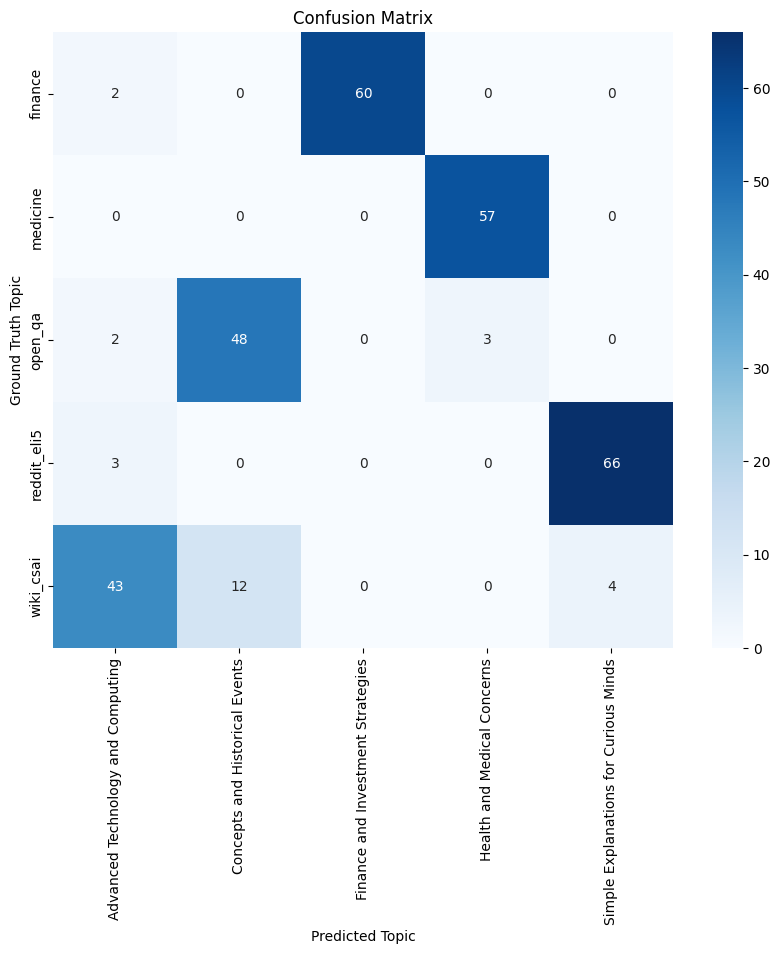

In [43]:
dataset = pd.read_csv("data/gpt_vs_human/multisource_testing.csv")
df = pd.read_csv("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-reducer_results.csv")
with open("pipeline_results/multisource_testing/LLMProposerMultiModel-ClusterSampler-AxisReducer-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-axes_to_topic.json") as f:
    axes_to_topic = json.load(f)
df = df.merge(dataset[["question", "source"]], on="question", how="left")

# Create a confusion matrix
confusion_matrix = pd.crosstab(df['source'], df['topic'], rownames=['Ground Truth'], colnames=['Predicted'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Topic')
plt.ylabel('Ground Truth Topic')
plt.title('Confusion Matrix')
# plt.show()
plt.savefig("figs/gpt_vs_human_confusion_topic_matrix.pdf", bbox_inches="tight")

In [44]:
metrics = pd.read_json("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-metrics.json")
scores = pd.read_json("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-results.json")


def display_metrics(metric_file):
       metrics = pd.read_json(metric_file)
       metric = [p for p in metrics.columns if "mean_diff" in p and "avg" in p][0]
       p_val = [p for p in metrics.columns if "p_value" in p][0]
       kappas = [p for p in metrics.columns if "Cohen's Kappa" in p and "0" in p]
       metrics["Cohn's kappa mean"] = metrics[kappas].mean(axis=1)
       summary_metrics = metrics[["topic", "axis", "support", metric, p_val, "Cohn's kappa mean"]].sort_values(metric)
       columns = ['topic', 'vibe', 'support', 'Vibe Delta',
              'p-value', "Cohn's kappa mean"]
       # round metric and pval to 3 decimal places
       summary_metrics[metric] = summary_metrics[metric].apply(lambda x: round(x, 3))
       summary_metrics[p_val] = summary_metrics[p_val].apply(lambda x: round(x, 3))
       summary_metrics.columns = columns
       # sort by vibe then by topic
       summary_metrics = summary_metrics.sort_values(by=['vibe', 'topic']).reset_index(drop=True)
       return summary_metrics[["vibe", "topic"] + columns[2:]]
display_metrics("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-metrics.json")


,vibe,topic,support,Vibe Delta,p-value,Cohn's kappa mean
0,Confidence and Assertiveness: High: 'Definitive guidance and claims.' Low: 'Shows uncertainty and cautious advice.',Finance and Investment Strategies,98,-0.041,0.452,0.202646
1,Confidence and Assertiveness: High: 'Definitive guidance and claims.' Low: 'Shows uncertainty and cautious advice.',Health and Medical Concerns,105,0.151,0.001,0.124067
2,Detail and Specificity: High: 'Detailed and comprehensive explanations.' Low: 'General advice and brief explanations.',Advanced Technology and Computing,74,-0.054,0.183,0.184050
3,Detail and Specificity: High: 'Detailed and comprehensive explanations.' Low: 'General advice and brief explanations.',Concepts and Historical Events,121,-0.449,0.000,0.349447
4,Detail and Specificity: High: 'Detailed and comprehensive explanations.' Low: 'General advice and brief explanations.',Finance and Investment Strategies,98,-0.400,0.000,0.252677
5,Detail and Specificity: High: 'Detailed and comprehensive explanations.' Low: 'General advice and brief explanations.',Health and Medical Concerns,105,-0.538,0.000,0.275843
6,Detail and Specificity: High: 'Detailed and comprehensive explanations.' Low: 'General advice and brief explanations.',Simple Explanations for Curious Minds,102,-0.034,0.476,0.295115
7,Use of Examples and Analogies: High: 'Frequent use of examples and analogies.' Low: 'Minimal or no examples.',Advanced Technology and Computing,74,-0.151,0.034,0.170557
8,Use of Examples and Analogies: High: 'Frequent use of examples and analogies.' Low: 'Minimal or no examples.',Simple Explanations for Curious Minds,102,0.067,0.235,0.192049


In [45]:
from components.sampler import match_set_to_centroids

def load_experiment(results_dir, tag):
  results = pd.read_json(f"{results_dir}/{tag}-eval-results.json")
  axis_to_topic = pd.read_json(f"{results_dir}/{tag}-axes_to_topic.json", orient='records')
  eval_axes = results['axis'].value_counts().index.tolist()
  print(f"\n\n{results['axis'].value_counts()}\n{eval_axes}\n\n")
  if os.path.exists(f"{results_dir}/{tag}-topic_to_example.json"):
    topic_to_example = pd.read_json(f"{results_dir}/{tag}-topic_to_example.json", orient='records')
  else:
    topic_to_example = None
  topic_centroids = np.load(f"{results_dir}/{tag}-topic-centroids.np.npy", allow_pickle=True).item()
  return results, axis_to_topic, topic_to_example, topic_centroids


In [46]:
metrics = display_metrics("pipeline_results/multisource_testing_train/no_rubric_test/LLMProposerMultiModel-ClusterSampler_5-JuryRanker/human_answers-chatgpt_answers_k3_seed42-eval-metrics.json")
metrics[metrics["p-value"] <= 0.05]

,vibe,topic,support,Vibe Delta,p-value,Cohn's kappa mean
0,Cautionary statements: High: Advises professional consultation Low: Direct advice,Health and Medical Concerns,55,-0.200,0.004,0.084900
3,"Detail Level: High: Comprehensive with examples and context Low: Concise, summarized",Historical and Cultural Facts,40,-0.525,0.000,0.051948
8,"Formatting & Structure: High: Well structured, formal tone Low: Simple, casual",Financial and Investment Advice,49,-0.439,0.000,0.198483
9,"Formatting & Structure: High: Well structured, formal tone Low: Simple, casual",Technology and Science Concepts,59,-0.106,0.013,0.044284
15,Personalization: High: Direct address and first-person perspective Low: Impersonal,Health and Medical Concerns,55,0.205,0.005,0.065340
17,Speculation and Interpretation: High: Explores multiple theories Low: Straightforward interpretation,Simplified Explanations,47,0.447,0.000,0.116327


In [47]:
results_dir = "pipeline_results/multisource_testing_train/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury"
tag = "human_answers-chatgpt_answers_k3_seed42"
results, axis_to_topic, topic_to_example, topic_centroids = load_experiment(results_dir, tag)
metrics = display_metrics("pipeline_results/multisource_testing_train/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-metrics.json")
metrics[metrics["p-value"] <= 0.05]



axis
Length of responses: High: In-depth Low: Concise                                                        250
Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured                            144
Formatting & Structure: High: Well structured, formal tone Low: Simple, casual                          108
Personalization: High: Direct address and first-person perspective Low: Impersonal                      102
Detail Level: High: Comprehensive with examples and context Low: Concise, summarized                     99
Empathy and emotional support: High: Shows empathy Low: Factual                                          55
Cautionary statements: High: Advises professional consultation Low: Direct advice                        55
Disclaimer Usage: High: Uses disclaimers Low: Confident, without disclaimers                             49
Complexity of Language: High: Complex vocabulary and sentences Low: Simple language                      47
Speculation and Inter

,vibe,topic,support,Vibe Delta,p-value,Cohn's kappa mean
0,Cautionary statements: High: Advises professional consultation Low: Direct advice,Health and Medical Concerns,55,-0.836,0.000,0.377221
1,Complexity of Language: High: Complex vocabulary and sentences Low: Simple language,Simplified Scientific Explanations,47,0.239,0.000,0.345814
3,"Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured",Health and Medical Concerns,55,-0.677,0.000,0.219047
4,"Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured",Historical and Cultural Queries,40,-0.294,0.003,0.092287
5,"Detail Level: High: Comprehensive with examples and context Low: Concise, summarized",Historical and Cultural Queries,40,-0.762,0.000,0.145450
9,"Formatting & Structure: High: Well structured, formal tone Low: Simple, casual",Financial and Investment Advice,49,-0.816,0.000,0.238684
10,"Formatting & Structure: High: Well structured, formal tone Low: Simple, casual",Technology and Science Concepts,59,-0.102,0.026,0.216860
11,Length of responses: High: In-depth Low: Concise,Financial and Investment Advice,49,-0.372,0.000,0.277218
12,Length of responses: High: In-depth Low: Concise,Health and Medical Concerns,55,-0.473,0.000,0.364289
13,Length of responses: High: In-depth Low: Concise,Historical and Cultural Queries,40,-1.056,0.000,0.169881


In [48]:
from components.metrics_utils import prepare_data_for_decision_tree, expand_dataframe_with_axes, train_decision_tree

results_dir = "pipeline_results/multisource_testing_train/relative_ranker/LLMProposerMultiModel-ClusterSampler_5-RelativeRanker"
tag = "human_answers-chatgpt_answers_k3_seed42"
results, axis_to_topic, topic_to_example, topic_centroids = load_experiment(results_dir, tag)
clf, clf_reg, model_metrics = train_decision_tree(results, results, ["human", "chatgpt"], show=False)



axis
Length of responses: High: In-depth Low: Concise                                                        201
Detail Level: High: Comprehensive with examples and context Low: Concise, summarized                    146
Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured                            144
Formatting & Structure: High: Well structured, formal tone Low: Simple, casual                          108
Personalization: High: Direct address and first-person perspective Low: Impersonal                      102
Empathy and emotional support: High: Shows empathy Low: Factual                                          55
Cautionary statements: High: Advises professional consultation Low: Direct advice                        55
Disclaimer Usage: High: Uses disclaimers Low: Confident, without disclaimers                             49
Complexity of Language: High: Complex vocabulary and sentences Low: Simple language                      47
Speculation and Inter

In [49]:
results_dir = "pipeline_results/multisource_testing_train/relative_ranker/LLMProposerMultiModel-ClusterSampler_5-RelativeRanker"
tag = "human_answers-chatgpt_answers_k3_seed42"
results, axis_to_topic, topic_to_example, topic_centroids = load_experiment(results_dir, tag)
metrics = display_metrics("pipeline_results/multisource_testing_train/relative_ranker/LLMProposerMultiModel-ClusterSampler_5-RelativeRanker/human_answers-chatgpt_answers_k3_seed42-eval-metrics.json")
metrics[metrics["p-value"] <= 0.05]



axis
Length of responses: High: In-depth Low: Concise                                                        201
Detail Level: High: Comprehensive with examples and context Low: Concise, summarized                    146
Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured                            144
Formatting & Structure: High: Well structured, formal tone Low: Simple, casual                          108
Personalization: High: Direct address and first-person perspective Low: Impersonal                      102
Empathy and emotional support: High: Shows empathy Low: Factual                                          55
Cautionary statements: High: Advises professional consultation Low: Direct advice                        55
Disclaimer Usage: High: Uses disclaimers Low: Confident, without disclaimers                             49
Complexity of Language: High: Complex vocabulary and sentences Low: Simple language                      47
Speculation and Inter

,vibe,topic,support,Vibe Delta,p-value,Cohn's kappa mean
0,Cautionary statements: High: Advises professional consultation Low: Direct advice,Health and Medical Concerns,55,-0.350,0.000,0.269955
1,Complexity of Language: High: Complex vocabulary and sentences Low: Simple language,Simplified Explanations,47,0.266,0.002,0.230479
2,"Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured",Financial and Investment Advice,49,-0.281,0.001,0.242805
3,"Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured",Health and Medical Concerns,55,-0.450,0.000,0.096599
4,"Confidence in Answers: High: Acknowledges uncertainties Low: Direct, assured",Historical and Cultural Facts,40,-0.731,0.000,0.015187
5,"Detail Level: High: Comprehensive with examples and context Low: Concise, summarized",Historical and Cultural Facts,40,-0.919,0.000,0.435897
7,"Detail Level: High: Comprehensive with examples and context Low: Concise, summarized",Technology and Science Concepts,59,-0.208,0.033,0.521726
8,"Disclaimer Usage: High: Uses disclaimers Low: Confident, without disclaimers",Financial and Investment Advice,49,-0.184,0.046,0.163310
9,Empathy and emotional support: High: Shows empathy Low: Factual,Health and Medical Concerns,55,-0.364,0.000,0.271344
10,"Formatting & Structure: High: Well structured, formal tone Low: Simple, casual",Financial and Investment Advice,49,-0.612,0.000,0.291019


In [4]:
df = pd.read_csv("data/gpt_vs_human/multisource_testing.csv")
# slit up inot half train set half test set with an equaal repersentation from each source
train = df.groupby('source').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)
test = df[~df.index.isin(train.index)]
train.to_csv("data/gpt_vs_human/multisource_testing_train.csv", index=False)
test.to_csv("data/gpt_vs_human/multisource_testing_test.csv", index=False)